<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/Ex3_PJ61403_DenseNet121_ClassWeights_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [ ]:
!nvidia-smi

Mon Feb 22 13:45:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions_Ver2 import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [ ]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

EPOCHS = 100
NUM_CLASSES = 4
BATCH_SIZE = 32

LR = 1e-4

# Data

## Clone Data

In [ ]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-25-25

Cloning into 'PJ61403_DATA_split_50-25-25'...
remote: Enumerating objects: 4366, done.
remote: Total 4366 (delta 0), reused 0 (delta 0), pack-reused 4366
Receiving objects: 100% (4366/4366), 167.13 MiB | 17.22 MiB/s, done.
Resolving deltas: 100% (284/284), done.
Checking out files: 100% (5061/5061), done.


In [ ]:
train_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/train'

val_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val'

test_dir = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test'

## Data Augmentation

In [ ]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_aug.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode ='categorical')

val_generator = val_aug.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical')

test_generator = test_aug.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 121 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


# Model

## Base Model

In [ ]:
!git clone https://github.com/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning

Cloning into 'JSTP22_Skin-Diseases-Classification-Using-Machine-Learning'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1392 (delta 23), reused 15 (delta 3), pack-reused 1339
Receiving objects: 100% (1392/1392), 826.09 MiB | 30.92 MiB/s, done.
Resolving deltas: 100% (809/809), done.
Checking out files: 100% (187/187), done.


In [ ]:
base_model = tf.keras.models.load_model('/content/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/PJ61403_work_Ver2/Ex2/model_weights/Ex2_HAM10000_DenseNet121_ClassWeights_Ver2_model.h5')

In [ ]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## New Model

In [ ]:
num_layers = len(base_model.layers)

In [ ]:
for i in range(num_layers):
    base_model.layers[i].trainable = False

x = base_model.layers[num_layers-2].output
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.25)(x)
prediction = Dense(4, activation='softmax')(x)

new_model = Model(inputs=base_model.input,outputs=prediction)

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [ ]:
new_model.compile(optimizer=Adam(LR), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='Ex3_PJ61403_ClassWeights_model_Ver2.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [ ]:
history = new_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        callbacks=[early_stop, model_checkpoint, reduce_lr_rate])

Epoch 1/100
4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 30.2500 - loss: 1.8146 - accuracy: 0.2645

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4/4 [==============================] - 18s 4s/step - batch: 1.5000 - size: 30.2500 - loss: 1.8146 - accuracy: 0.2645 - val_loss: 1.6772 - val_accuracy: 0.3167
Epoch 2/100
4/4 [==============================] - 2s 760ms/step - batch: 1.5000 - size: 30.2500 - loss: 1.6642 - accuracy: 0.3554 - val_loss: 1.6182 - val_accuracy: 0.3833
Epoch 3/100
4/4 [==============================] - 4s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.7257 - accuracy: 0.2727 - val_loss: 1.5679 - val_accuracy: 0.4500
Epoch 4/100
4/4 [==============================] - 4s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.6083 - accuracy: 0.3388 - val_loss: 1.5266 - val_accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 4s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.5313 - accuracy: 0.4298 - val_loss: 1.4843 - val_accuracy: 0.5167
Epoch 6/100
4/4 [==============================] - 4s 1s/step - batch: 1.5000 - size: 30.2500 - loss: 1.5155 - accuracy: 0.4711 - val_loss: 1.4430 - val_accur

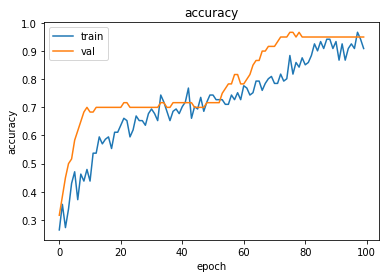

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

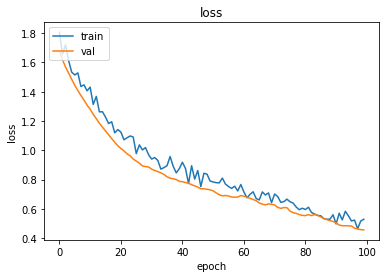

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [ ]:
test_model = tf.keras.models.load_model('/content/Ex3_PJ61403_ClassWeights_model_Ver2.h5')

In [ ]:
num_test_files = len(test_generator.filenames)

In [ ]:
test_generator.reset()

In [ ]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[17  0  0  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  0  0 15]]


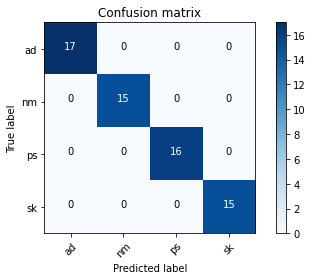

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


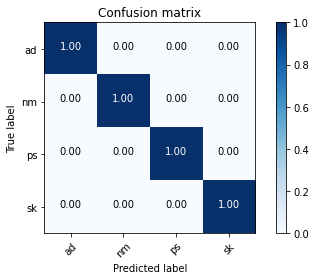

In [ ]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [ ]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[17  0  0  0]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  0  0 15]]
Classification Report
              precision    recall  f1-score   support

          ad       1.00      1.00      1.00        17
          nm       1.00      1.00      1.00        15
          ps       1.00      1.00      1.00        16
          sk       1.00      1.00      1.00        15

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



## TP FP FN TN

In [ ]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [ ]:
TruePositive= np.diag(cm_2)

In [ ]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[17 15 16 15]
Sum of True Positive:  63


### FP

In [ ]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [ ]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[0, 0, 0, 0]
Sum of False Positive:  0


### FN

In [ ]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [ ]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[0, 0, 0, 0]
Sum of False Negative:  0


### TN

In [ ]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [ ]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[46, 48, 47, 48]
Sum of True Negative:  189


### Check TP + FP +FN + TN = Test set

In [ ]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True


## PYCM

In [ ]:
!pip3 install pycm==3.0

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 573kB 8.3MB/s 


In [ ]:
from pycm import *

In [ ]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [ ]:
py_cm.classes

[0, 1, 2, 3]

In [ ]:
py_cm.table

{0: {0: 17, 1: 0, 2: 0, 3: 0},
 1: {0: 0, 1: 15, 2: 0, 3: 0},
 2: {0: 0, 1: 0, 2: 16, 3: 0},
 3: {0: 0, 1: 0, 2: 0, 3: 15}}

In [ ]:
print(py_cm)

Predict  0        1        2        3        
Actual
0        17       0        0        0        

1        0        15       0        0        

2        0        0        16       0        

3        0        0        0        15       





Overall Statistics : 

95% CI                                                            (1.0,1.0)
ACC Macro                                                         1.0
ARI                                                               1.0
AUNP                                                              1.0
AUNU                                                              1.0
Bangdiwala B                                                      1.0
Bennett S                                                         1.0
CBA                                                               1.0
CSI                                                               1.0
Chi-Squared                                                       189.0
Chi-Squared DF          

### Average AUC

In [ ]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3])/len(py_cm.AUC)

In [ ]:
print('Average AUC: ', AV_AUC)

Average AUC:  1.0


### Average Senstivity

In [ ]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3])/len(py_cm.TPR)

In [ ]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  1.0


### Average Specificity

In [ ]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3])/len(py_cm.TNR)

In [ ]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  1.0


## Grad-CAM

In [ ]:
last_conv2d = 'conv5_block16_2_conv'

### AD

In [ ]:
ad_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ad/ad1.jpg'

Model prediction:
	ad             	(0)	with probability 0.992
	nm             	(1)	with probability 0.005
	sk             	(3)	with probability 0.002
	ps             	(2)	with probability 0.001
Explanation for 'ad'


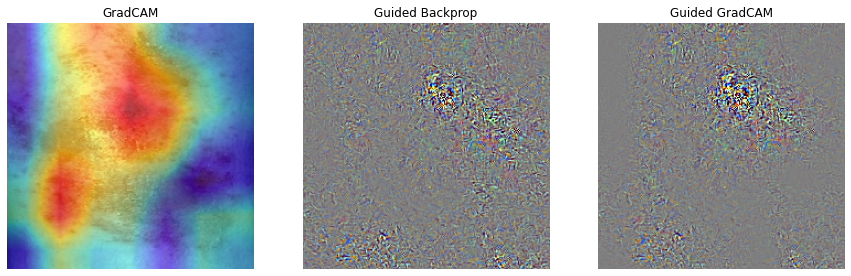

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ad_img, layer_name=last_conv2d)

### NM

In [ ]:
nm_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/nm/nm4.jpg'

Model prediction:
	nm             	(1)	with probability 0.577
	ad             	(0)	with probability 0.238
	ps             	(2)	with probability 0.128
	sk             	(3)	with probability 0.056
Explanation for 'nm'


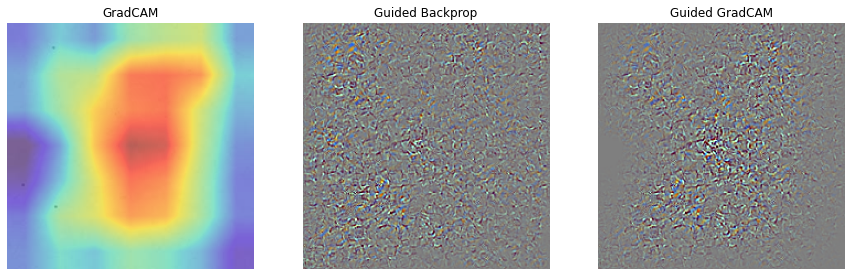

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, nm_img, layer_name=last_conv2d)

### PS

In [ ]:
ps_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/val/ps/ps57.jpg'

Model prediction:
	ps             	(2)	with probability 0.986
	sk             	(3)	with probability 0.013
	nm             	(1)	with probability 0.000
	ad             	(0)	with probability 0.000
Explanation for 'ps'


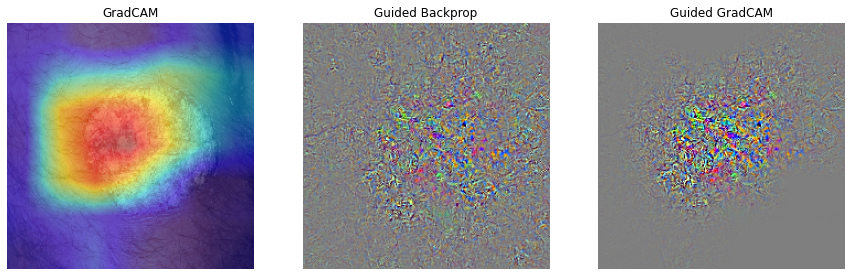

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ps_img, layer_name=last_conv2d)

### SK

In [ ]:
sk_img = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test/sk/sk4.jpg'

Model prediction:
	sk             	(3)	with probability 0.992
	ps             	(2)	with probability 0.005
	ad             	(0)	with probability 0.002
	nm             	(1)	with probability 0.001
Explanation for 'sk'


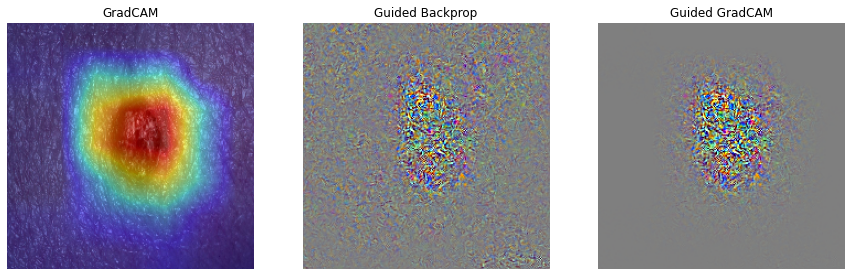

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, sk_img, layer_name=last_conv2d)

# Download Model

In [ ]:
from google.colab import files

In [60]:
files.download('/content/Ex3_PJ61403_ClassWeights_model_Ver2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>